In [420]:
import tensorflow as tf 
from tensorflow import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import modules.utils as tools

In [473]:
window_size = 10
forecasting_range = 50
dimensionality = 230
cutoff = 5

In [474]:
import pickle
with open('Data/pickles/interpolated_data.pkl', 'rb') as f:
    interpolated_data = pickle.load(f)
    #times =interpolated_data[battery_no][cycle_no][:,0]

In [475]:
interpolated_data = np.array(interpolated_data)

<ipython-input-475-a688f9e6847a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  interpolated_data = np.array(interpolated_data)


In [476]:
def clip_interpolated_data(cutoff, interpolated_data):
    for i in range(3):
        for j in range(168):
            interpolated_data[i,j] = interpolated_data[i, j][cutoff:,:]
    return interpolated_data.tolist()

In [477]:
interpolated_data = clip_interpolated_data(2, interpolated_data)

In [478]:
minimum = 1.7555322021036255
maximum = 4.2331462538907605

def min_max_scaling(all_data, minimum = 1.7555322021036255, maximum = 4.2331462538907605):
    return (all_data - minimum)/(maximum-minimum)

interpolated_data = np.array(interpolated_data)
interpolated_data = min_max_scaling(interpolated_data).tolist()

<ipython-input-478-f30853e6ef68>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  interpolated_data = np.array(interpolated_data)


In [479]:
num_examples = len(interpolated_data[0]) - window_size - forecasting_range
X_5 = np.empty((num_examples, window_size, dimensionality))
Y_5 = np.empty((num_examples, forecasting_range, dimensionality))
for i in range(num_examples):
    for j in range(window_size):
        X_5[i, j, :] = interpolated_data[0][i+j][:,1][:dimensionality]
    for k in range(forecasting_range):
        Y_5[i, k, :] = interpolated_data[0][i+k+window_size][:,1][:dimensionality]
    

In [480]:
num_examples = len(interpolated_data[1]) - window_size - forecasting_range
X_6 = np.empty((num_examples, window_size, dimensionality))
Y_6 = np.empty((num_examples, forecasting_range, dimensionality))
for i in range(num_examples):
    for j in range(window_size):
        X_6[i, j, :] = interpolated_data[1][i+j][:,1][:dimensionality]
    for k in range(forecasting_range):
        Y_6[i, k, :] = interpolated_data[1][i+k+window_size][:,1][:dimensionality]

In [481]:
num_examples = len(interpolated_data[2]) - window_size - forecasting_range
X_7 = np.empty((num_examples, window_size, dimensionality))
Y_7 = np.empty((num_examples, forecasting_range, dimensionality))
for i in range(num_examples):
    for j in range(window_size):
        X_7[i, j, :] = interpolated_data[2][i+j][:,1][:dimensionality]
    for k in range(forecasting_range):
        Y_7[i, k, :] = interpolated_data[2][i+k+window_size][:,1][:dimensionality]

In [482]:
from sklearn.model_selection import train_test_split
X_5_train, X_5_test, Y_5_train, Y_5_test = train_test_split(X_5, Y_5, random_state = 42, train_size = 0.8)
X_6_train, X_6_test, Y_6_train, Y_6_test = train_test_split(X_6, Y_6, random_state = 42, train_size = 0.8)
X_7_train, X_7_test, Y_7_train, Y_7_test = train_test_split(X_7, Y_7, random_state = 42, train_size = 0.8)

In [483]:
X_train = np.concatenate((X_5_train, X_6_train, X_7_train), axis = 0)
Y_train = np.concatenate((Y_5_train, Y_6_train, Y_7_train), axis = 0)
X_test = np.concatenate((X_5_test, X_6_test, X_7_test), axis = 0)
Y_test = np.concatenate((Y_5_test, Y_6_test, Y_7_test), axis = 0)

In [484]:
X_train_swapped = np.swapaxes(X_train, 1, 2)
X_test_swapped = np.swapaxes(X_test, 1, 2)
Y_train_swapped = np.swapaxes(Y_train, 1, 2)
Y_test_swapped = np.swapaxes(Y_test, 1, 2)

## Model building

In [485]:
## Custom loss function
## y_true, y_pred have dimensions (dimensionality x forecasting_range)
def weighted_loss(weights):
    def loss(y_true, y_pred):
        squared_difference = tf.math.square(y_true - y_pred)
        weighted_squared_difference = tf.math.multiply(squared_difference, weights)
        return tf.reduce_mean(weighted_squared_difference, axis=-1)
    return loss



In [ ]:
##Testing custom weights

In [486]:
row = np.linspace(start=1.5, stop=0.5, num=forecasting_range)
weights_1 = np.tile(row, (dimensionality, 1))

In [385]:
column_1 = np.linspace(start = 1.5, stop= 0.5, num = int(dimensionality/2))
column_2 = np.linspace(start=0.5, stop=1.5, num = int(dimensionality/2))
column = np.concatenate((column_1, column_2), axis = 0)
column = column.reshape(-1, 1)
weights_2 = np.tile(column, (1, forecasting_range))

In [487]:
def create_model(loss,forecasting_range=50,dimensionality=200,window_size=10, patience=10, n_neurons=100):
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')]
    lstm_rnn_model = keras.models.Sequential()
    #simple_rnn_model.add(keras.layers.Flatten(input_shape= [window_size, 1]))
    lstm_rnn_model.add(keras.layers.LSTM(n_neurons, input_shape=[None, window_size], activation='tanh', return_sequences=True))
    lstm_rnn_model.add(keras.layers.LSTM(n_neurons, activation='tanh', return_sequences=True))
    lstm_rnn_model.add(keras.layers.TimeDistributed(keras.layers.Dense(forecasting_range)))
    lstm_rnn_model.compile(optimizer='Adam', loss=loss)

    return lstm_rnn_model
#history = lstm_rnn_model.fit(X_train_swapped, Y_train_swapped, epochs=1000, validation_data = (X_test_swapped, Y_test_swapped), callbacks=my_callbacks, verbose=1)


In [336]:
#lstm_rnn_model.save('weights_2_predict_cycles.h5')

In [488]:
weights_1_model = create_model(loss=weighted_loss(weights_1),dimensionality=dimensionality)
#weights_1_model.load_weights('weights_1_predict_cycles.h5')
history = weights_1_model.fit(X_train_swapped, Y_train_swapped, epochs=1000, validation_data = (X_test_swapped, Y_test_swapped), callbacks=my_callbacks, verbose=1)


Epoch 1/1000
9/9 [==============================] - 3s 195ms/step - loss: 0.3810 - val_loss: 0.0729
Epoch 2/1000
9/9 [==============================] - 1s 122ms/step - loss: 0.0524 - val_loss: 0.0211
Epoch 3/1000
9/9 [==============================] - 1s 120ms/step - loss: 0.0204 - val_loss: 0.0174
Epoch 4/1000
9/9 [==============================] - 1s 124ms/step - loss: 0.0164 - val_loss: 0.0139
Epoch 5/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0134 - val_loss: 0.0118
Epoch 6/1000
9/9 [==============================] - 1s 123ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 7/1000
9/9 [==============================] - 1s 122ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 8/1000
9/9 [==============================] - 1s 124ms/step - loss: 0.0082 - val_loss: 0.0075
Epoch 9/1000
9/9 [==============================] - 1s 134ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 10/1000
9/9 [==============================] - 1s 128ms/step - loss: 0.0065 - val_loss: 0.0063

In [489]:
weights_1_model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, None, 100)         44400     
_________________________________________________________________
lstm_69 (LSTM)               (None, None, 100)         80400     
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 50)          5050      
Total params: 129,850
Trainable params: 129,850
Non-trainable params: 0
_________________________________________________________________


In [490]:
def prepare_data_for_plot(model, X_5, X_6, X_7, Y_5, Y_6, Y_7):
    X_5_swapped = np.swapaxes(X_5, 1, 2)
    Y_5_preds = np.swapaxes(model.predict(X_5_swapped), 1, 2)
    X_6_swapped = np.swapaxes(X_6, 1, 2)
    Y_6_preds = np.swapaxes(model.predict(X_6_swapped), 1, 2)
    X_7_swapped = np.swapaxes(X_7, 1, 2)
    Y_7_preds = np.swapaxes(model.predict(X_7_swapped), 1, 2)
    return Y_5_preds, Y_6_preds, Y_7_preds


In [491]:
Y_5_preds, Y_6_preds, Y_7_preds = prepare_data_for_plot(weights_1_model, X_5, X_6, X_7, Y_5, Y_6, Y_7)

In [492]:
def plot_projections(X_data, Y_data, starting_cycle=0, step=20, is_actual=False, dimensionality=200):
    if is_actual:
        text = 'Actual'
    else:
        text = 'Projected'
    plt.figure
    plt.title(text + ' discharge curves for the next 50 cycles')
    plt.ylim(bottom=0.4)
    plt.xlabel('Time step (1 unit = 10s)')
    plt.ylabel('Voltage (normalised)')
    x = np.arange(start=0, stop=dimensionality, step=1)
    for j in range(0,forecasting_range,step):
        voltages = Y_data[starting_cycle, j, :]
        plt.plot(x, voltages, color = 'blue', label=text + ' next 50 cycles')
    for i in range(window_size):
        voltages = X_data[starting_cycle, i, :]
        plt.plot(x, voltages, color = 'orange', label='10 cycles')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

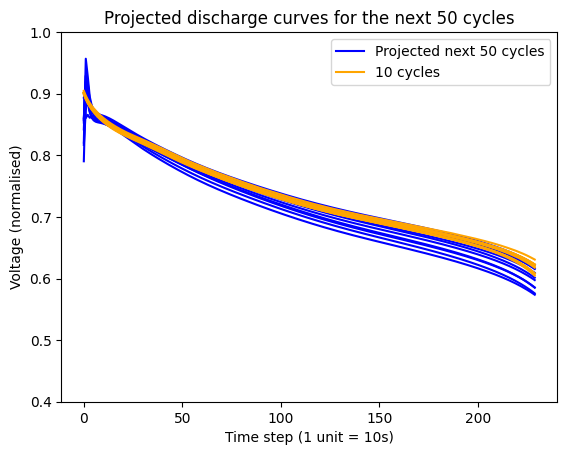

In [493]:
plot_projections(X_5, Y_5_preds, starting_cycle=100, step=5, dimensionality=dimensionality)

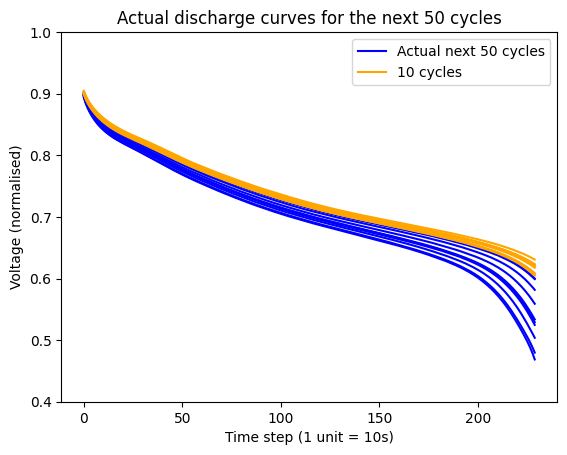

In [494]:
plot_projections(X_5, Y_5, starting_cycle=100, step=5, is_actual=True, dimensionality=dimensionality)

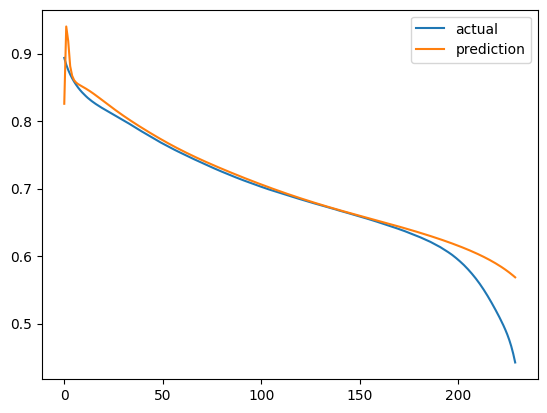

In [496]:
x = np.arange(start=0, stop=230, step=1)
plt.plot(x, Y_5[100,49,:], label='actual')
plt.plot(x, Y_5_preds[100,49,:], label='prediction')
plt.legend()
plt.show()